In [71]:
import argparse        
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
from keras.models import Model
from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image
from imutils import paths
import cv2
import imageio


%matplotlib inline

## Step 1 : Loading The Dataset

In [41]:
# Adding the path to the test and train sets as lists


imagePathsTrain = list(paths.list_images("cityscapes_data/train/"))
imagePathsTest = list(paths.list_images("cityscapes_data/val/"))

In [29]:


n1 = cv2.imread(imagePathsTrain[0]).shape
train_cases = len(imagePathsTrain)

n2 = cv2.imread(imagePathsTest[0]).shape
test_cases = len(imagePathsTest)

500


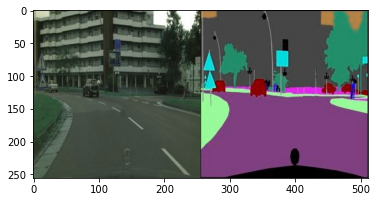

In [30]:
train_image = cv2.imread(imagePathsTrain[0])
test_image = cv2.imread(imagePathsTest[0])

plt.imshow(test_image)
plt.imshow(train_image)


shape1 = train_image.shape
shape2 = test_image.shape

m1 = shape1[1]
width1 = m1//2
m2 = shape2[1]
width2 = m2//2

In [25]:
X_train = np.zeros((len(imagePathsTrain),n1[0],width1,n1[2]))
Y_train = np.zeros((len(imagePathsTrain),n1[0],width1,n1[2]))
X_test = np.zeros((len(imagePathsTest),n2[0],width2,n2[2]))
Y_test = np.zeros((len(imagePathsTest),n2[0],width2,n2[2]))


for i in range(train_cases):
    train_image = cv2.imread(imagePathsTrain[i])
    X_train[i] = train_image[ :, : width1, :]
    Y_train[i] = train_image[ :, width1 : , :]

    
for j in range(test_cases):
    test_image = cv2.imread(imagePathsTest[j])
    X_test[j] = train_image[ :, : width2, :]
    Y_test[j] = train_image[ :, width2 : , :]

In [49]:
X_train, X_test, Y_train, Y_test = X_train/255, X_test/255, Y_train/255, Y_test/255

## Step 2  : Defining the model

In [60]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [85]:
def encoder(inputs = None, n_filters = 32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    if dropout_prob > 0:
         
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        
        next_layer = MaxPooling2D(2,strides=2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [86]:
input_size=(256, 256, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = Encoder(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)
model1.summary()


inputs = Input(input_size)
cblock1 = Encoder(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)
model2.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_51 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output 

In [87]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    return conv

In [88]:
input_size1=(32,32, 256)
input_size2 = (64,64, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)
model1.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 32, 32, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 64, 64, 32)  73760       ['input_34[0][0]']               
 spose)                                                                                           
                                                                                                  
 input_35 (InputLayer)          [(None, 64, 64, 128  0           []                               
                                )]                                                         

In [91]:
def unet_model(input_size=(235,256, 3), n_filters=32, n_classes=30):
    inputs = Input(input_size)
    cblock1 = encoder(inputs=inputs, n_filters=n_filters*1)
    cblock2 = encoder(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = encoder(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = encoder(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    cblock5 = encoder(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    
    ublock6 =  upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    
    return model

In [92]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [93]:
unet.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_66 (Conv2D)             (None, 256, 256, 32  896         ['input_37[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_67 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_66[0][0]']              
                                )                                                          

                                                                                                  
 conv2d_82 (Conv2D)             (None, 256, 256, 32  18464       ['concatenate_6[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_83 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_82[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_83[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85

In [94]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [95]:
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 32

unet.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_train, Y_train),shuffle=True)

Epoch 1/40


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\91830\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\91830\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\91830\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\91830\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\91830\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\91830\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\91830\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\91830\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\91830\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\91830\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\91830\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\91830\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\91830\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\91830\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\91830\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\91830\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\91830\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\91830\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\91830\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\91830\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\91830\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\91830\AppData\Local\Temp/ipykernel_13984/1887255671.py", line 5, in <module>
      unet.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_train, Y_train),shuffle=True)
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\91830\anaconda3\lib\site-packages\keras\backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [2097152,30] and labels shape [6291456]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_4891]